In [2]:
# Import Dependencies
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float, Date
from sqlalchemy import func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flask import Flask, jsonify

In [3]:
# Create an engine sqlite database
engine = create_engine("sqlite:///hawaii.sqlite", connect_args={'check_same_thread': False})

In [4]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
# lists out tables
Base.classes.keys()

['measurements', 'stations']

In [6]:
# Save references
measurements = Base.classes.measurements
stations = Base.classes.stations

In [7]:
# Create a database session object
session = Session(engine)

In [8]:
measurements.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [9]:
# look at min/max dates for analysis
x = session.query(func.min(measurements.date),func.max(measurements.date)).first()
x

('2010-01-01', '2017-08-23')

## Precipitation Analysis

In [10]:
# Query average precipitation for last year
prcp_last12_months = session.query(measurements.date, func.avg(measurements.prcp)).\
                filter(measurements.date.between('2016-08-24', '2017-08-23')).\
                group_by(measurements.date).order_by(measurements.date).all()

In [11]:
len(prcp_last12_months)

365

In [12]:
# Put results of query into dataframe
prcp_last12_months_df = pd.DataFrame(prcp_last12_months, columns=['Date', 'Precipitation']).set_index('Date')

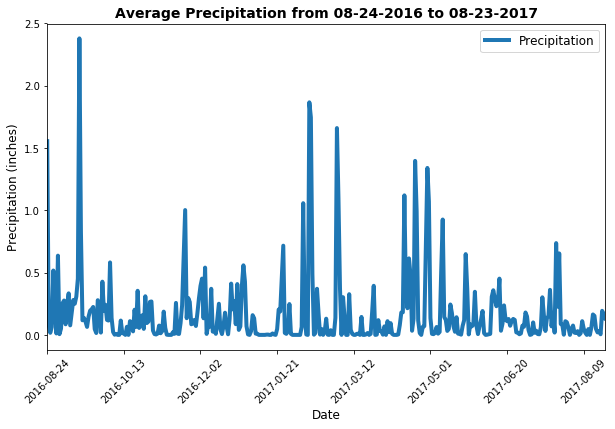

In [13]:
# Create graph to display results of query
prcp_last12_months_df.plot(x=prcp_last12_months_df.index, y= 'Precipitation',figsize = (10,6), linewidth = 4, rot = 45)

# Set titles and labels
plt.title("Average Precipitation from 08-24-2016 to 08-23-2017", fontweight= 'bold', fontsize = 14)
plt.xlabel("Date", fontsize= 12)
plt.ylabel("Precipitation (inches)", fontsize= 12)
plt.legend(fontsize =12)

# Show chart
plt.show()

In [14]:
# summary statistics
prcp_last12_months_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Station Analysis

In [15]:
# Query to count total number of stations
station_count = session.query(stations.station).count()
print("There are a total of %s stations." % station_count)

There are a total of 9 stations.


In [16]:
# Query to find most active stations
active_stations = session.query(measurements.station, func.count(measurements.station)).\
                group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [26]:
# Query to get the most active station
most_active_station = active_stations = session.query(measurements.station).\
                group_by(measurements.station).order_by(func.count(measurements.station).desc()).first()
most_active_station_cnt = active_stations = session.query(func.count(measurements.station)).\
                group_by(measurements.station).order_by(func.count(measurements.station).desc()).first()
print("%s is the station with the highest number (%s) of observations." % (most_active_station[0], most_active_station_cnt[0]))

USC00519281 is the station with the highest number (2772) of observations.


In [27]:
# Query to get the last 12 months of temperature observations by the station with highest number of observations
tobs_last12_months = session.query(measurements.station, measurements.date,
    func.max(measurements.tobs)).\
    filter(measurements.date.between('2016-08-24', '2017-08-23')).group_by(measurements.date).all()

# put query results into dataframe
tobs_last12_months_df = pd.DataFrame(tobs_last12_months, columns=['Station', 'Date', 'Max Tobs'])

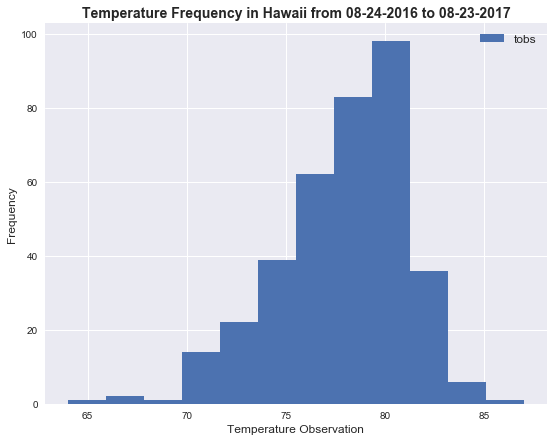

In [30]:
plt.style.use("seaborn")

# Create graph to display frequency
fig = plt.figure(figsize = (9,7))
plt.hist(tobs_last12_months_df['Max Tobs'], bins= 12, label = 'tobs')

# Set titles and labels
plt.title("Temperature Observation Frequency in Hawaii from 08-24-2016 to 08-23-2017", fontweight= 'bold', fontsize = 14)
plt.xlabel("Temperature Observation", fontsize= 12)
plt.ylabel("Frequency", fontsize= 12)
plt.legend(fontsize =12)


plt.show()

## Temperature Analysis

In [31]:
# definie function to query the max, min, and average temperature observation for defined dates
def calc_temps(start_date, end_date):
    print("Your vacation starts on %s and ends on %s." % (start_date, end_date))
    x = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.date.between(start_date, end_date)).first()
    temp_summary = {"Minimum Temperature": x[0],
                   "Maximum Temperature": x[1],
                   "Average Temperature": x[2]}
    print(temp_summary)
    return temp_summary

In [32]:
# use vacation days (May 8, 2018 to May 17, 2018) as dates for the function
temp_summary = calc_temps('2017-05-08', '2017-05-17')
temp_summary

Your vacation starts on 2017-05-08 and ends on 2017-05-17.
{'Minimum Temperature': 66, 'Maximum Temperature': 80, 'Average Temperature': 74.85185185185185}


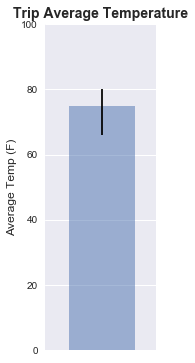

In [35]:
plt.style.use("seaborn")

# Create graph to display frequency
avg_temp = int(round(temp_summary["Average Temperature"]))
min_error = avg_temp-temp_summary["Minimum Temperature"]
max_error = temp_summary["Maximum Temperature"]-avg_temp
errorbar = [[min_error], [max_error]]
fig = plt.figure(figsize = (2,6))
width = 1.2
plt.xlim(-0.05,2)
plt.ylim(0,100)

plt.bar(1, avg_temp, width =width,alpha=0.5, yerr = errorbar)

# Set titles and labels
plt.title("Trip Average Temperature", fontweight= 'bold', fontsize = 14)
plt.ylabel("Average Temp (F)", fontsize= 12)
plt.xticks([])

plt.show()

## Climate App

In [36]:
tobs_lastyear = session.query( measurements.date,func.avg(measurements.tobs)).\
    filter(measurements.date.between('2016-08-24', '2017-08-23')).group_by(measurements.date).all()
tobs_lastyear_dict = dict(tobs_lastyear)

In [38]:
all_stations = session.query(measurements.station).\
                group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
allstations = [station[0] for station in all_stations]

In [40]:
tobs_only = session.query(measurements.tobs).\
    filter(measurements.date.between('2016-08-24', '2017-08-23')).all()
tobsonly = [tobs[0] for tobs in tobs_only]

In [ ]:
app = Flask(__name__)

@app.teardown_request
def remove_session(ex=None):
    session.remove()

@app.route("/")
def index():
    return ("Welcome to the Climate App!<br/> \
         Available Routes:<br/> \
         /api/v1.0/precipitation<br/> \
         /api/v1.0/stations<br/> \
         /api/v1.0/tobs<br/>")

@app.route("/api/v1.0/precipitation")
def precipitation():
    return jsonify(tobs_lastyear_dict)

@app.route("/api/v1.0/stations")
def stations():
    all_stations = session.query(measurements.station).\
                group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
    return jsonify(all_stations)

@app.route("/api/v1.0/tobs")
def tobs():
    return jsonify(tobs_only)

@app.route("/api/v1.0/<start>")
def start(start_date):
    x = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.date== start_date).first()
    temp_summary = {"Minimum Temperature": x[0],
                   "Maximum Temperature": x[1],
                   "Average Temperature": x[2]}
    return jsonify(temp_summary)

@app.route("/api/v1.0/<start>/<end>")
def start_end(start,end):
    x = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.date.between(start, end)).first()
    temp_summary = {"TMIN": x[0],
                "TMAX": x[1],
                "TAVG": x[2]}
    return jsonify(temp_summary)
            
            
if __name__ == "__main__":
    app.run(debug=True,port=5000)